## Tutorial 01: processing on pancreas dataset

**In this tutorial we provide a step-by-step explaination of all processing steps that are taken in the $\kappa$-velo pipeline. The steps in the pipeline are also described in section 2.4 of our bioRxiv preprint (Marot-Lassauzaie and Bouman, et al. 2022). By highlighting a few example genes, we show how the processing steps change the data. We hope that this gives you some insight into every function that we are using.**

*Initiation data: Tuesday 23.05.2022*\
*Lastest update: Sunday 29.05.2022*\
*Author: Brigitte Bouman (brigittejoanne.bouman@mdc-berlin.de)*

In [2]:
### load libraries

# standard libraries
import numpy as np

# single-cell libraries
import anndata as ad
import scanpy as sc

# plotting libraries
import matplotlib.pyplot as plt

# import our own functions
import velocity

### Load dataset

**Load dataset into Notebook**\
Here, we load the dataset into this Notebook. If your dataset is stored in a different directory on your computer, make sure to change the path.

In [3]:
### load dataset
dataset_path = "/Volumes/Tim_Extern/IEO/HNSCC_Descriptive/saves/AnnData/sc_treated_velocity.h5ad"
adata = ad.read_h5ad(dataset_path)
adata

AnnData object with n_obs × n_vars = 5523 × 60708
    obs: 'sample', 'bcs', 'batch', 'clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene_name', 'gene_count_corr'
    uns: 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

The dataset is loaded into object "adata". This object contains three matrices: spliced, unspliced and X. The X matrix is a copy of the spliced matrix. Most Scanpy and scVelo functions work with the X matrix. In this tutorial, any steps that we execute on the spliced and unspliced matrix in the adata object, we will also execute on the X matrix.

The loaded also dataset comes with the UMAP embedding that was calculated in the scVelo publication. Let's plot the dataset to get an idea of the cell types and general structure of the dataset. 

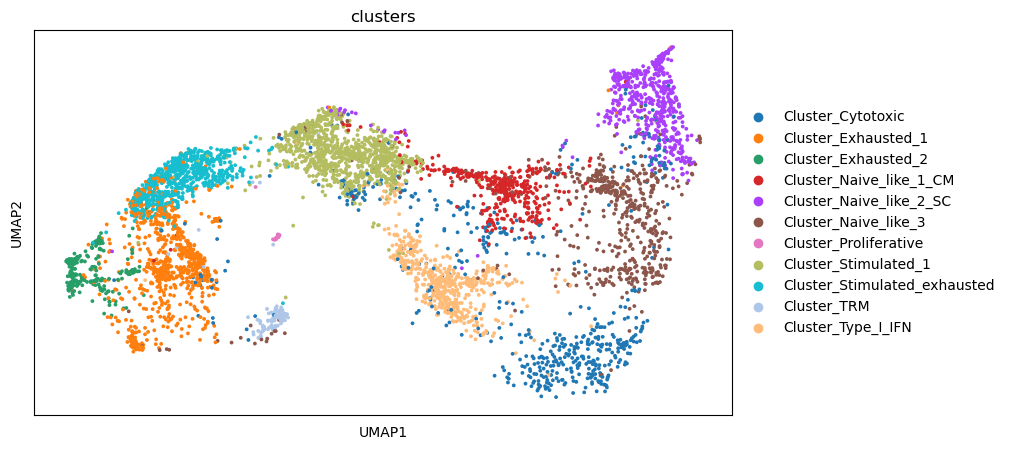

In [4]:
### plot dataset
fig, axs = plt.subplots(1, 1, figsize=(9,5), frameon=False)
sc.pl.umap(adata, color="clusters", size=30, ax=axs)

Let's have a quick look at how many total spliced and unspliced counts (counts of all genes summed) are found in each cell. 

In [6]:
### sum the spliced and unspliced counts
adata.obs["spliced_counts"] = np.array(adata.layers["spliced"].sum(axis=1)).flatten()
adata.obs["unspliced_counts"] = np.array(adata.layers["unspliced"].sum(axis=1)).flatten()

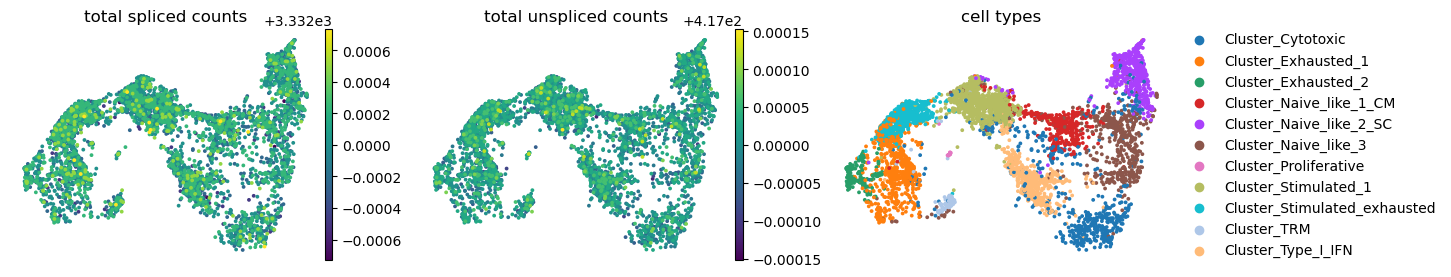

In [7]:
### plot the total spliced and unspliced counts in UMAP
fig, axs = plt.subplots(1, 3, figsize=(15, 3), frameon=False)
sc.pl.umap(adata, color="spliced_counts", size=30, ax=axs[0], show=False, title="total spliced counts", frameon=False)
sc.pl.umap(adata, color="unspliced_counts", size=30, ax=axs[1], show=False, title="total unspliced counts", frameon=False)
sc.pl.umap(adata, color="clusters", size=30, ax=axs[2], show=False, title="cell types", frameon=False)

plt.show()

### Plotting raw counts

In the spliced and unspliced matrix we have a count for each cell for every gene. Since this particular dataset has 3969 cells, we have 3696 measurements of the spliced and unspliced counts for every gene. At this point, these measurements are completely "raw". This means that they have not been normalised, scaled, filtered or underwent any other processing procedure since the reads were counted. Before we start our processing pipeline, let's have a look at the spliced and unspliced measurements of a few selected genes. Feel free to change the gene names to have a look at other genes as well. However, at this point all 27998 genes are still included in the dataset, so be aware that there might be a lot of genes that do not show any counts at all. 

In [8]:
### select genes of interest
test_genes = ["ENSG00000188404.10"]

TypeError: unsupported operand type(s) for %: 'int' and 'NoneType'

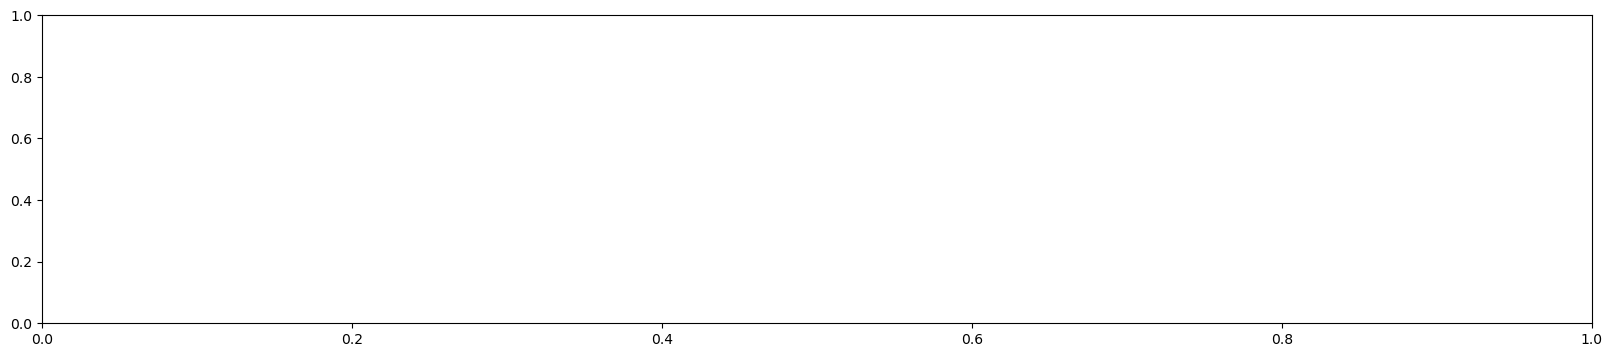

In [9]:
velocity.pl.kinetics.scatter(adata, test_genes, use_raw=True, ticks=True, figsize = (20,4))

### Selecting highly variable genes (HVGs)

**Why do we select HVGs**\
Our first processing step is selecting only the genes that show high variability. At this moment, our dataset has almost 28000 genes. To decrease the dimensions (=number of genes), of the single-cell dataset we select only those genes that have a high variability. This allows us to focus on genes that are likely to contain biologicaly interesting variance: genes that have the same number of counts for all cells do not contain biological signal allowing us to do bioinformatic analysis s.a. differentiating cell types.

**How do we select HVGs**\
To select HVGs we use our `get_hvgs` functions, which uses analytic Pearson residuals to identify the variability of each gene (Lause et al. 2021 https://doi.org/10.1186/s13059-021-02451-7). There are a few different ways of selecting highly variable genes. However, we prefer this method over other methods, because it recovers both low- and high-expression genes with high variance. HVGs are identified based on the spliced counts of genes. 

In [10]:
hvgs = velocity.pp.filtering.get_hvgs(adata, no_of_hvgs=5000, theta=100, layer='spliced')

/Users/timnoahkempchen/velocity_package/velocity/processing/filtering.py:28: RuntimeWarning: invalid value encountered in true_divide
  z = (counts - mu) / np.sqrt(mu + (np.square(mu) / theta))


In this dataset we selected the top 5000 most variable genes. The number you choose depends on your dataset, so feel free to play around with this setting if you are using a different dataset. One thing to take into consideration are the filtering steps later where we filter out even more genes. 

Next, we keep only the genes in the dataset that are in the top 5000 HVGs.

In [11]:
adata = adata[:, hvgs]
adata

View of AnnData object with n_obs × n_vars = 5523 × 5000
    obs: 'sample', 'bcs', 'batch', 'clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'spliced_counts', 'unspliced_counts'
    var: 'gene_name', 'gene_count_corr'
    uns: 'neighbors', 'pca', 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

### Subset for genes with high U and S counts

**Why do we select high U-S genes**\
Here, we filter the genes once more to include only genes that have sufficient spliced and unspliced counts. In one of the next steps the spliced and unspliced counts for each gene in each cell are imputed using the nearest neighbours to decrease the noise in the measurements. However, imputation can create artificial clouds of points in the unspliced/spliced portrait for some genes with extremely low unspliced and/or spliced counts, for which the dynamics cannot be reliably recovered. The velocity recovered for those genes would not correspond to clear signal observed in the raw counts. Therefore, we filter out all genes for which the spliced and/or unspliced counts are below a certain threshold. 

**How do we select high U-S genes**\
For our dataset, only the genes with a maximum spliced or unspliced count above 3 are kept for further downstream analyses. We select those genes using our function `get_high_us_genes`. In the function you set the threshold for both the unspliced (minlim_u) and spliced counts (minlim_s).

In [12]:
minlim = 3
us_genes = velocity.pp.filtering.get_high_us_genes(adata, minlim_u=minlim, minlim_s=minlim)
len(us_genes)

1884

To get an idea of the maximum spliced and unspliced counts for each gene, we create a scatterplot. In this scatterplot we can see that out of our 5000 genes (that are left after selecting the HVGs) many genes barely have any counts. The red lines indicate the threshold of 3 that we set for this particular dataset (for both the spliced and unspliced counts). The 716 genes that are above both thresholds are coloured in black in the plot.  

In [13]:
### get maximum spliced and unspliced counts for each gene
max_unspliced = np.array(np.max(adata.layers["unspliced"], axis=0)).flatten()
max_spliced = np.array(np.max(adata.layers["spliced"], axis=0)).flatten()

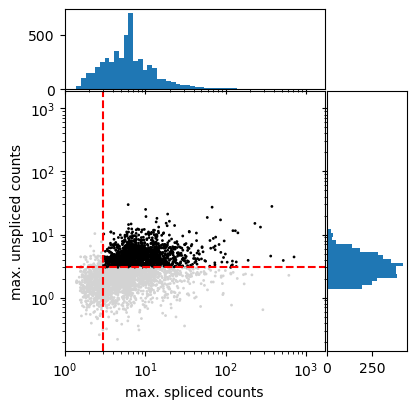

In [14]:
### create figure
x = max_spliced
y = max_unspliced

colors = []
for idx in range(len(max_spliced)):
    if ((max_spliced[idx] > minlim) & (max_unspliced[idx] > minlim)):
        colors.append('black')
    else:
        colors.append('lightgrey')

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

fig = plt.figure(figsize=(4, 4))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

### the scatter plot:
ax.scatter(max_spliced, max_unspliced, s=1, c=colors)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel('max. spliced counts')
ax.set_ylabel('max. unspliced counts')
ax.axhline(y=minlim, color='r', linestyle='--')
ax.axvline(x=minlim, color='r', linestyle='--')

### the histograms:
bins = 50
hist, bins = np.histogram(x, bins=bins)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
ax_histx.hist(x, bins=logbins)
ax_histy.hist(y, bins=logbins, orientation='horizontal')

plt.show()

Let's test whether our 4 genes of interest are part of the selection of genes that are above both thresholds:

In [15]:
np.intersect1d(us_genes, test_genes)

array([], dtype=object)

It looks like all 4 genes have counts above our set threshold!

For our next steps we keep only the genes above the threshold in our dataset.

In [16]:
adata = adata[:,us_genes]

In [17]:
adata

View of AnnData object with n_obs × n_vars = 5523 × 1884
    obs: 'sample', 'bcs', 'batch', 'clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'spliced_counts', 'unspliced_counts'
    var: 'gene_name', 'gene_count_corr'
    uns: 'neighbors', 'pca', 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

### Normalise counts

**Why do we normalise**\
Due to variability inherent to experimental protocols, the percentage of reads that is captured might vary from cell to cell. With normalisation we compensate for cells having different numbers of total reads by correcting the counts for each gene with the total number of counts in that cell. If you are more interested in reasons to normalise and best practices, we recommend the publication "*Current best practices in single-cell RNA-seq analysis: a tutorial*" from Luecken & Theis (Molecular Systems Biology, 2019)(https://doi.org/10.15252/msb.20188746). 

**How do we normalise**\
Since the total RNA content of each cell is determined by both the spliced and unspliced counts. We use them combined to get the total number of counts. We can do this using our funcion `normalise_layers`, which normalises both the spliced and unspliced layer in our adata object. We select mode `combined`, to use the the counts of both spliced and unspliced. If instead, you perform normalisation on the two matrices separately, select mode `separate`.

In [18]:
velocity.pp.normalisation.normalise_layers(adata, mode='combined', norm='L1')

total_counts not given


Since normalising changes the counts in the spliced and unspliced matrix, we will have a look at how the operation has changed our genes of interest. 

TypeError: unsupported operand type(s) for %: 'int' and 'NoneType'

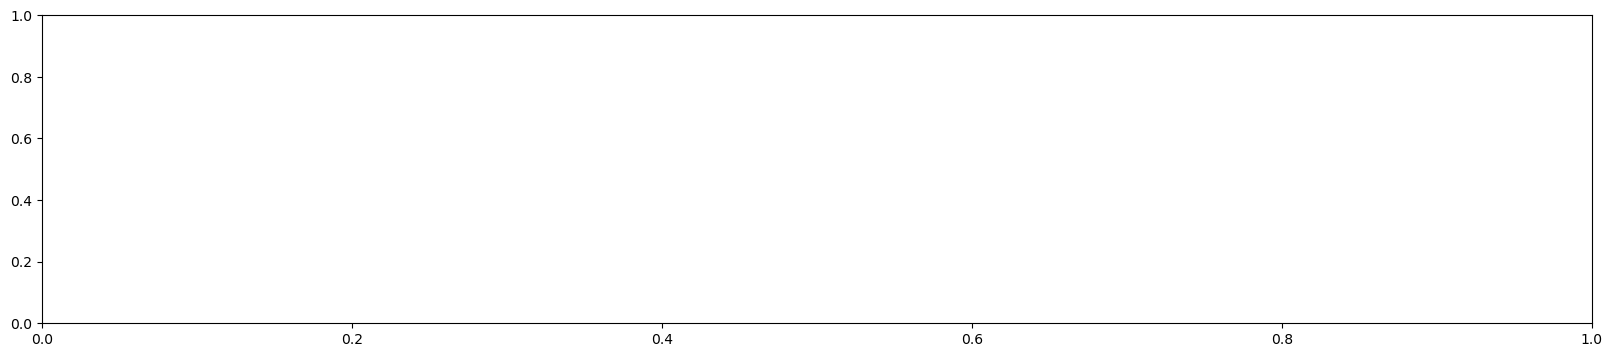

In [19]:
velocity.pl.kinetics.scatter(adata, test_genes, use_raw=True, ticks=True, figsize = (20,4))

### Impute counts

**Why do we impute the counts**\
Unfortunately, as you can see the spliced and unspliced counts are very noisy. Therefore, we can not directly use them to fit the parameters. To denoise the counts, we are using a process called "imputation". For each cell we search for the top X cells that are most similar to this cell, also called the top X nearest neighbours. The count value for each genes is then replaced by the average value for this gene in it's 30 nearest neighbours (note that the nearest neighbour is always the cell itself). This step smoothens the count values in each cell for each gene.

**How do we impute the counts**\
Both spliced and unspliced counts have to be imputed. We can to that using our function `impute_counts`. In this function we specify how many neighbours we want to impute over (in the case of the pancreas dataset we take 30). We also specify the layer that is used to find the nearest neighbours. In this case we will use only the spliced counts to identify the nearest neighbours of each cells. Lastly, we also specify the number of principal components that will be used for defining the nearest neighbours. Instead of using the specified layer as is to define the nearest neighbours, the function first reduces the dimensions using PCA. In this case we select `n_pcs = 15`, meaning that only the first 15 principal components are used to find a cells nearest neighbours.

In [20]:
velocity.pp.imputation.impute_counts(adata, n_neighbours = 30, layer_NN = 'spliced', n_pcs = 15)

Imputation is one of steps that changes the counts a lot. Let's have a look at how the step changes our genes of interest. And feel free to scroll back to see how they looked before processing.

TypeError: unsupported operand type(s) for %: 'int' and 'NoneType'

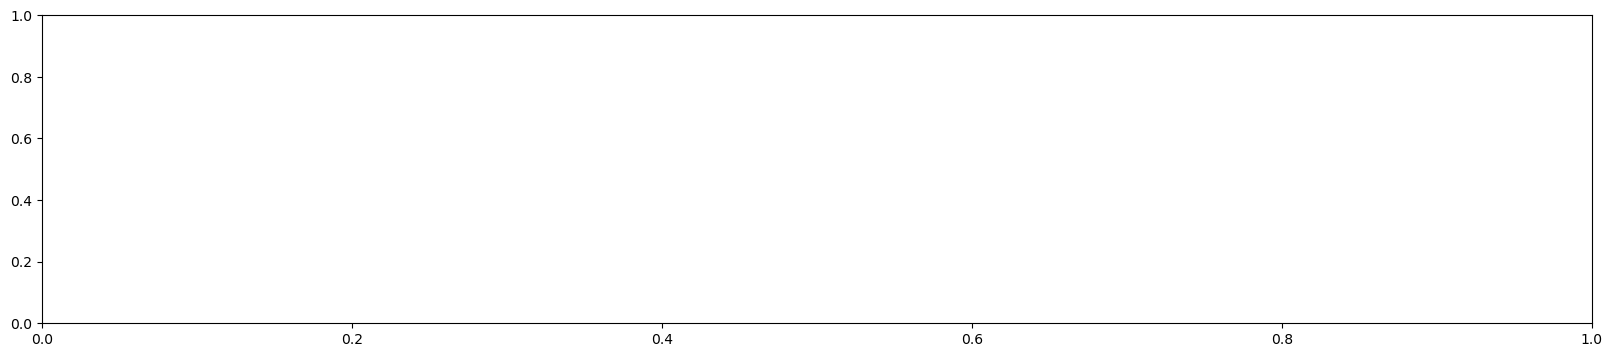

In [21]:
velocity.pl.kinetics.scatter(adata, test_genes, use_raw=False, ticks=True, figsize = (20,4))

In [22]:
adata

AnnData object with n_obs × n_vars = 5523 × 1884
    obs: 'sample', 'bcs', 'batch', 'clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'spliced_counts', 'unspliced_counts'
    var: 'gene_name', 'gene_count_corr'
    uns: 'neighbors', 'pca', 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'